# Classificazione con n-grammi

In [1]:
import numpy as np
import json
import os

## File conllu

I file conllu contengono l'annotazione linguistica di tutte le frasi dei post dell'utente, separate da ritorni a capo.
L'annotazione della frase è preceduta da un'**intestazione** in cui le righe iniziano con il simbolo "**#**"

Esempio:

    # newpar
    # sent_id = 13
    # text = Io infatti aspetto ancora risposta da loro!

Si possono trovare anche il tag "# newdoc" e "# newpar" che indicano rispettivamente che si è passati a un nuovo documento o a un nuovo paragrafo.

Dopo l'intestazione c'è l'analisi linguistica. 
C'è una riga per ogni token, che contiene i campi dell'annotazione separati da **tab** (\t):

Esempio:

    1	Io	io	PRON	PE	Number=Sing|Person=1|PronType=Prs	3	nsubj	_	_
    2	infatti	infatti	ADV	B	_	3	advmod	_	_
    3	aspetto	aspettare	VERB	V	Mood=Ind|Number=Sing|Person=1|Tense=Pres|VerbForm=Fin	0	root	_	_
    4	ancora	ancora	ADV	B	_	5	advmod	_	_
    5	risposta	risporre	VERB	V	Gender=Fem|Number=Sing|Tense=Past|VerbForm=Part	3	xcomp	_	_
    6	da	da	ADP	E	_	7	case	_	_
    7	loro	loro	PRON	PE	Number=Plur|Person=3|PronType=Prs	5	obl:agent	_	SpaceAfter=No
    8	!	!	PUNCT	FS	_	3	punct	_	_

Caso particolare sono le "preposizioni articolate": ad esse è associata una riga che contiene solamente la preposizione intera, il cui indice indica gli indici delle parole in cui è stata scomposta. Sono gli unici indici che contengono il simbolo "-". Di seguito sono riportate le parti in cui è stata scomposta.
Esempio:

    4	belle	bello	ADJ	A	Gender=Fem|Number=Plur	0	root	_	_
    5-6	del	_	_	_	_	_	_	_	_
    5	di	di	ADP	E	_	7	case	_	_
    6	il	il	DET	RD	Definite=Def|Gender=Masc|Number=Sing|PronType=Art	7	det	_	_
    7	forum...e	forum...e	NOUN	S	Gender=Masc|Number=Sing	4	obl	_	_
    

## Caricamento dataset

I file delle annotazioni linguistiche si trovano tutti all'interno della stessa cartella.
Ciascun file contiene tutti i post di un utente.
Le informazioni di ciascun utente si trovano sempre nel dizionario salvato durante il preprocessing.

Per prima dividiamo i documenti di train da quelli di test.

In [2]:
conllu_dir = 'data/Tag-it/profiling_output/linguistic_annotation/'
user_info_path  = 'data/Tag-it/preprocessed_dataset/user_info.json'

In [3]:
def load_user_info(src_path):
    with open(src_path, 'r') as src_file:
        user_info = json.load(src_file)
    return user_info

In [4]:
user_info_dict = load_user_info(user_info_path)

Definiamo la classe Document, Sentence e Token

In [5]:
class Document:
    
    def __init__(self, document_path, user_info_dict):
        self.document_path = document_path
        self.doc_id = None
        self.split = None
        self.topic = None
        self.age = None
        self.gender = None
        self._load_doc_info(document_path, user_info_dict)
        self.sentences = []
        self.features = None
        
    def _load_doc_info(self, document_path, user_info_dict):
        self.doc_id = document_path.split('/')[-1].split('.')[0]
        self.split = user_info_dict[self.doc_id]['split']
        self.topic = user_info_dict[self.doc_id]['topic']
        self.age = user_info_dict[self.doc_id]['age']
        self.gender = user_info_dict[self.doc_id]['gender']
             
    def add_sentence(self, sentence):
        self.sentences.append(sentence)
    
    # Per dopo
        
    def get_num_tokens(self):
        num_words = 0
        for sentence in self.sentences:
            num_words = num_words + sentence.get_num_tokens()
        return num_words
    
    def get_num_chars(self):
        num_chars = 0
        for sentence in self.sentences:
            sentence_char_len = sentence.get_num_chars()
            num_chars = num_chars + sentence_char_len
        return num_chars
        
class Sentence:
    
    def __init__(self):
        self.tokens = []
        
    def add_token(self, token):
        self.tokens.append(token)
    
    # Per dopo
        
    def get_words(self):
        return [token.word for token in self.tokens]
    
    def get_lemmas(self):
        return [token.lemma for token in self.tokens]
    
    def get_pos(self):
        return [token.pos for token in self.tokens]
    
    def get_num_tokens(self):
        return len(self.tokens)
    
    def get_num_chars(self):
        num_chars = 0
        for token in self.tokens:
            num_chars = num_chars + token.get_num_chars()
        num_chars = num_chars + self.get_num_tokens() - 1 # contiamo anche gli spazi
        return num_chars
    
    def __str__(self):
        return ' '.join([token.word for token in self.tokens])

class Token:
    
    def __init__(self, word, lemma, pos):
        self.word = word
        self.lemma = lemma
        self.pos = pos
        
    # Per dopo
        
    def get_num_chars(self):
        return len(self.word)

In [6]:
def load_document_sentences(document):
    sentence = Sentence()
    for line in open(document.document_path, 'r'):
        if line[0].isdigit():  # se la riga inizia con un numero
            splitted_line = line.strip().split('\t')
            if '-' not in splitted_line[0]:  # se l'id della parola non contiene un trattino
                token = Token(splitted_line[1], splitted_line[2], splitted_line[3])
                sentence.add_token(token)
        if line == '\n':  # se la riga è vuota significa che la frase è finita
            document.add_sentence(sentence)
            sentence = Sentence()

In [7]:
all_documents = []
for file_name in os.listdir(conllu_dir):
    file_path = os.path.join(conllu_dir, file_name)
    document = Document(file_path, user_info_dict)
    load_document_sentences(document)
    all_documents.append(document)

In [8]:
sample_document = all_documents[0]
for sentence in sample_document.sentences[:5]:
    tokens = [token.word for token in sentence.tokens]
    print(' - '.join(tokens)+'\n')

Bella - diego

Guarda - rispondo - velocemente - perchè - sto - per - uscire - .

Ironizzavo - su - uno - di - i - miti - recenti - di - il - napoli - , - i - cross - di - maggio - .

Senza - andare - a - tirare - i - paragoni - con - gli - altri - o - a - sottolineare - gli - assist - ( - ci - sarebbe - pure - quello - contro - la - roma - l' - anno - scorso - ) - era - una - battuta - Che - poi - per - me - maggio - sia - da - sostituire - con - un - giocatore - più - giovane - e - di - qualità - superiore - è - un - altro - discorso - .

Hai - ragione - , - miliardi - !



# Estrazione features

Prendiamo come feature di un documento il numero di occorrenze dei suoi n-grammi. Questi n-grammi possono essere estratti a partire da:

- Caratteri
- Forme
- Lemmi
- POS

Per n = 1, 2, 3, ...

Ciascun n-gramma diventa una feature a cui è associato il numero di occorrenze nel documento (eventualmente normalizzato).

Non conoscendo a priori quali saranno tutti gli n-grammi del training set, non possiamo costruire direttamente un vettore di features del documento.
Esiste però la classe **DictVectorizer** di scikit-learn che trasforma un insieme di dizionari di features in una matrice di features.

Per prima cosa creiamo quindi il dizionario di features associato a ciascun documento, e in fine, trasformiamo i dizionari in una matrice di features.
La matrice delle features sarà molto **sparsa**.


## Dict-vectorizer

![Dict-vectorizer](data/img/dict_vectorizer.png "dict_vectorizer")

![Matrice densa vs matrice sparsa](https://i0.wp.com/cmdlinetips.com/wp-content/uploads/2018/03/Sparse_Matrix.png?w=576&ssl=1)

# Estrazione degli n-grammi

![n-grammi](https://miro.medium.com/v2/resize:fit:720/format:webp/1*eiWYpN_bVLNYNjFy978vxQ.png "N-grammi")

In [9]:
sample_sentence = sample_document.sentences[2]
print(sample_sentence)

Ironizzavo su uno di i miti recenti di il napoli , i cross di maggio .


In [10]:
def extract_word_ngrams_from_sentence(word_ngrams, sentence, el, n):
    # creiamo una lista con tutte le parole
    if el == 'word':
        all_words = sentence.get_words()
    elif el == 'lemma':
        all_words = sentence.get_lemmas()
    elif el == 'pos':
        all_words = sentence.get_pos()
    else:
        raise Exception(f'Invalid element {el}')
    
    # scorriamo la lista delle parole ed estraiamo gli n-grammi
    for i in range(0, len(all_words) - n + 1): # -n+1 serve per non uscire dal vettore
        ngram_words = all_words[i: i + n]
        ngram = f'{el.upper()}_{n}_' + '_'.join(ngram_words)
        # print(f'{i}: {ngram_words} -> {ngram}')
        if ngram not in word_ngrams:
            word_ngrams[ngram] = 1
        else:
            word_ngrams[ngram] += 1

    return word_ngrams

In [11]:
extract_word_ngrams_from_sentence(dict(), sample_sentence, 'word', 1)

{'WORD_1_Ironizzavo': 1,
 'WORD_1_su': 1,
 'WORD_1_uno': 1,
 'WORD_1_di': 3,
 'WORD_1_i': 2,
 'WORD_1_miti': 1,
 'WORD_1_recenti': 1,
 'WORD_1_il': 1,
 'WORD_1_napoli': 1,
 'WORD_1_,': 1,
 'WORD_1_cross': 1,
 'WORD_1_maggio': 1,
 'WORD_1_.': 1}

In [12]:
def extract_char_ngrams_from_sentence(char_ngrams, sentence, n):
    # creiamo una lista con tutte le parole
    all_words = sentence.get_words()

    # creiamo una stringa che contenga tutte le parole separate tra spazi perchè vogliamo scorrere i caratteri
    all_words = ' '.join(all_words)
    # print(all_words)
    # all_words = all_words.lower()

    # scorriamo la stringa ed estraiamo gli n-grammi di caratteri
    for i in range(0, len(all_words) - n + 1):
        ngram_chars = all_words[i:i + n]
        ngram = f'CHAR_{n}_' + ngram_chars
        # print(f'{i}: {ngram_chars} -> {ngram}')

        if ngram not in char_ngrams:
            char_ngrams[ngram] = 1
        else:
            char_ngrams[ngram] += 1

    return char_ngrams

In [13]:
extract_char_ngrams_from_sentence(dict(), sample_sentence, 2);

## Estrazione delle features dei documenti

In [14]:
print(sample_document.features)

None


In [15]:
def extract_documents_ngrams(all_documents):
    for document in all_documents:
        document_ngrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(document_ngrams, sentence, 'word', 1)
            extract_word_ngrams_from_sentence(document_ngrams, sentence, 'word', 2)
            extract_char_ngrams_from_sentence(document_ngrams, sentence, 1)
            extract_char_ngrams_from_sentence(document_ngrams, sentence, 2)

        document.features = document_ngrams

In [16]:
extract_documents_ngrams(all_documents)

In [17]:
sample_document.features;

## Normalizzazione delle features

Dividiamo il numero di occorrenze di ogni feature, per la lunghezza del documento.

In [18]:
def normalize_ngrams(ngrams_dict, doc_len):
    for ngram in ngrams_dict:
        ngrams_dict[ngram] = ngrams_dict[ngram] / float(doc_len)
        
def extract_documents_ngrams_normalized(all_documents):
    for document in all_documents:
        word_unigrams = dict()
        word_bigrams = dict()
        char_unigrams = dict()
        char_bigrams = dict()
        for sentence in document.sentences:
            extract_word_ngrams_from_sentence(word_unigrams, sentence, 'word', 1)
            extract_word_ngrams_from_sentence(word_bigrams, sentence, 'word', 2)
            extract_char_ngrams_from_sentence(char_unigrams, sentence, 1)
            extract_char_ngrams_from_sentence(char_bigrams, sentence, 2)

        num_words = document.get_num_tokens()
        num_chars = document.get_num_chars()
        normalize_ngrams(word_unigrams, num_words)
        normalize_ngrams(word_bigrams, num_words)
        normalize_ngrams(char_unigrams, num_chars)
        normalize_ngrams(char_bigrams, num_chars)

        document_ngrams = word_unigrams | word_bigrams | char_unigrams | char_bigrams

        # user_features = dict()
        # for ngrams_dict in [word_unigrams, word_bigrams, char_unigrams, char_bigrams]:
        #     for ngram in ngrams_dict:
        #         user_features[ngram] = ngrams_dict[ngram]

        document.features = document_ngrams

In [19]:
extract_documents_ngrams_normalized(all_documents)

In [20]:
sample_document.features;

# Divisione training set e test set

In [21]:
def train_test_split(all_documents):
    train_features_dict, train_labels = [], []
    test_features_dict, test_labels = [], []
    
    for document in all_documents:
        if document.split == 'training':
            train_features_dict.append(document.features)
            train_labels.append(document.topic)
        else:
            test_features_dict.append(document.features)
            test_labels.append(document.topic)
    
    return train_features_dict, train_labels, test_features_dict, test_labels

In [22]:
train_features_dict, train_labels, test_features_dict, test_labels = train_test_split(all_documents)

In [23]:
len(train_features_dict), len(train_labels), len(test_features_dict), len(test_labels)

(1109, 1109, 411, 411)

In [24]:
train_labels[:5]

['SPORTS', 'METAL-DETECTING', 'ANIME', 'MEDICINE-AESTHETICS', 'BIKES']

## Filtro delle features poco frequenti
Per ridurre lo spazio delle features (n-grammi) si possono eliminare tutte quelle che compaiono in meno di tot. documenti.

Il filtro deve essere calcolato sulle features del **training set**!

In [25]:
def get_num_features(features_dict):
    all_features = set()
    for document_feats in features_dict:
        all_features.update(list(document_feats.keys()))
    return len(all_features)

In [26]:
get_num_features(train_features_dict)
print(f'Numero features: {get_num_features(train_features_dict)}')

Numero features: 418583


In [27]:
def filter_features(train_features_dict, min_occurrences):
    # contiamo ogni feature in quanti user diversi compare
    features_counter = dict()
    for document_features_dict in train_features_dict:
        for feature in document_features_dict:
            if feature in features_counter:
                features_counter[feature] += 1
            else:
                features_counter[feature] = 1

    # per ogni user, togliamo le features che compaiono in meno di "min_occurrences" utenti
    for document_features_dict in train_features_dict:
        document_features = list(document_features_dict.keys())
        for feature in document_features:
            if features_counter[feature] < min_occurrences:
                document_features_dict.pop(feature)

    return train_features_dict

In [28]:
train_features_dict = filter_features(train_features_dict, 5)
print(f'Numero features dopo il filtro: {get_num_features(train_features_dict)}')

Numero features dopo il filtro: 27554


## Creazione del vettore delle features

Per addestrare la SVM dobbiamo trasformare il nostro dizionario di features in un vettore di lunghezza fissa, che abbia una posizione fissa per ogni feature che compare nel training set.
Serve quindi una funzione che mappi ogni feature del dizionario ad una posizione sul vettore.

In [29]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
X_train = vectorizer.fit_transform(train_features_dict)
y_train = np.array(train_labels)

In [30]:
X_train

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 1033218 stored elements and shape (1109, 27554)>

In [31]:
vectorizer.get_feature_names_out(X_train).tolist();

# Normalizzazione delle features

Utilizzando una matrice sparsa non possiamo usare MinMaxScaler, perchè è importante mantenere la posizione degli 0.
Il MinMaxScaler spingerebbe a 0 elementi che non erano 0, e renderebbe diversi da 0 quelli che invece lo erano.

Utilizziamo **MaxAbsScaler** che divide ogni feature per il suo massimo in valore assoluto.
Le feature non saranno più nell'intervallo \[0, 1\], ma \[-1, 1\], e preserveranno la posizione degli 0.

In [32]:
from sklearn.preprocessing import MaxAbsScaler

scaler = MaxAbsScaler()
scaled_X_train = scaler.fit_transform(X_train)

## Addestramento del classificatore

In [33]:
from sklearn.svm import LinearSVC

svc = LinearSVC(dual=True, max_iter=10000)
svc.fit(scaled_X_train, train_labels)

LinearSVC(dual=True, max_iter=10000)

# Test

In [34]:
X_test = vectorizer.transform(test_features_dict)
scaled_X_test = scaler.transform(X_test)
y_test = np.array(test_labels)

In [35]:
from sklearn.metrics import classification_report

test_predictions = svc.predict(scaled_X_test)
print(classification_report(test_labels, test_predictions, zero_division=0))

                     precision    recall  f1-score   support

              ANIME       0.75      0.94      0.83        97
          AUTO-MOTO       0.74      0.91      0.82        76
              BIKES       1.00      0.08      0.15        12
        CELEBRITIES       1.00      0.59      0.74        22
      ENTERTAINMENT       1.00      0.11      0.20         9
MEDICINE-AESTHETICS       1.00      0.31      0.48        16
    METAL-DETECTING       0.94      0.62      0.74        26
             NATURE       1.00      0.36      0.53        11
              SMOKE       0.97      1.00      0.98        30
             SPORTS       0.80      0.97      0.88       103
         TECHNOLOGY       0.00      0.00      0.00         9

           accuracy                           0.80       411
          macro avg       0.84      0.54      0.58       411
       weighted avg       0.82      0.80      0.77       411



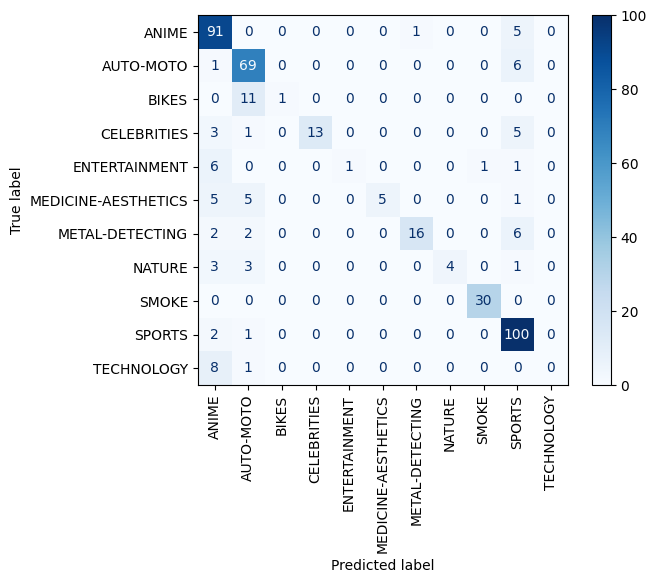

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, test_predictions, xticks_rotation='vertical', cmap='Blues');

## Feature importance

In [37]:
svc.classes_

array(['ANIME', 'AUTO-MOTO', 'BIKES', 'CELEBRITIES', 'ENTERTAINMENT',
       'MEDICINE-AESTHETICS', 'METAL-DETECTING', 'NATURE', 'SMOKE',
       'SPORTS', 'TECHNOLOGY'], dtype='<U19')

In [38]:
coefs = svc.coef_  # ndarray of shape (1, n_features) if n_classes == 2 else (n_classes, n_features)
coefs.shape

(11, 27554)

In [39]:
features_names = vectorizer.get_feature_names_out(X_train).tolist()
features_names;

Feature importance classe AUTO-MOTO


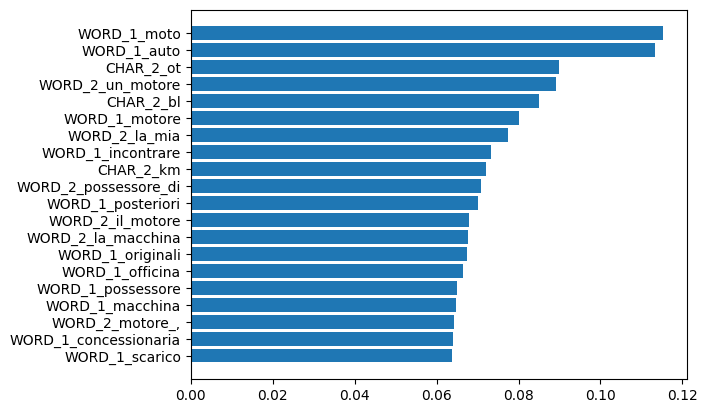

In [40]:
import matplotlib.pyplot as plt

idx = 1
class_coefs = coefs[idx]

feature_importances = {feature_name: coef for feature_name, coef in zip(features_names, class_coefs)}
sorted_feature_importances = dict(sorted(feature_importances.items(), key=lambda item: item[1], reverse=True))

# importances, names = zip(*sorted(zip(feature_importance, features)))

num_to_plot = 20
print(f'Feature importance classe {svc.classes_[idx]}')
plt.barh(range(num_to_plot), list(sorted_feature_importances.values())[:num_to_plot], align='center')
plt.yticks(range(num_to_plot), list(sorted_feature_importances.keys())[:num_to_plot])
plt.gca().invert_yaxis()
plt.show()